
# 🛒 고객 세분화 및 구매 패턴 분석 — 포트폴리오 노트북

**작성자:** 송민아  
**이메일:** minasong0131@naver.com  
**기간:** 2020.10 ~ 2022.09 (데이터 기준) / 2025-09-28 (정리본)  

본 노트북은 RFM 기반 고객 세분화 프로젝트의 **포트폴리오 제출용 정리본** 입니다.  
- **중복·실험용 셀을 제거**하고 **핵심 분석 코드만** 남겼습니다.  
- 실제 실행을 위해서는 데이터 경로/컬럼명을 프로젝트 환경에 맞게 확인하세요.
    


## 목차
1. 프로젝트 개요  
2. 데이터 로딩  
3. 전처리  
4. EDA (탐색적 데이터 분석)  
5. RFM 스코어링 및 등급  
6. RFM 등급별 매출 기여도  
7. 세그먼트별 특성 분석  
8. 프로모션 & 채널 효과  
9. 결론 및 시사점  


## 1) 프로젝트 개요  
- **문제 정의:** 모든 고객에게 동일한 마케팅 전략을 적용하는 것은 비효율적입니다. 고객의 가치와 특성을 고려한 개인화된 접근 방식이 필요합니다.  
- **프로젝트 목표:** RFM 분석을 통해 핵심 고객 그룹을 식별하고, 각 그룹의 인구통계학적 특성 및 구매 행동을 분석하여 맞춤형 마케팅 전략의 근거를 마련합니다.

## 2) 데이터 로딩  
- **데이터:** 2,240명의 고객 정보와 구매 기록을 포함한 23개의 변수로 구성된 데이터를 사용했습니다.  
- **주요 변수:** annual_income(연소득), recency(최근 방문일), amount_*(품목별 구매액), num_purchase_*(채널별 구매 횟수) 등이 포함되어 있습니다.

In [1]:
# 1. 라이브러리 임포트 및 환경 설정

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 한글 폰트 및 마이너스 기호 깨짐 방지 설정
plt.rc('font', family='NanumGothic')
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
print("라이브러리 임포트 및 환경 설정 완료.")

라이브러리 임포트 및 환경 설정 완료.


In [2]:
# 2. 데이터 로딩

# 데이터 경로. 실제 환경에 맞게 수정이 필요할 수 있습니다.
DATA_PATH = 'data/customer_data.csv' 
df = pd.read_csv(DATA_PATH, sep='\t')

# 데이터 기본 정보 확인
print("\n[데이터 샘플 (상위 3개)]")
display(df.head(3))
print("\n[데이터 기본 정보 및 결측치 현황]")
df.info()


[데이터 샘플 (상위 3개)]


,ID,signup_ym,birth_year,annual_income,marital_status,children,recency,amount_alcohol,amount_fruit,amount_meat,...,num_purchase_web,num_purchase_store,num_purchase_discount,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,revenue
0,5524,2020-12,1965,75579400.0,미혼,0,58,825500,114400,709800,...,8,4,3,0,0,0,0,0,1,11
1,2174,2022-06,1962,60247200.0,미혼,2,38,14300,1300,7800,...,1,2,2,0,0,0,0,0,0,11
2,4141,2021-11,1973,93096900.0,배우자 있음,0,26,553800,63700,165100,...,8,10,1,0,0,0,0,0,0,11



[데이터 기본 정보 및 결측치 현황]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     2240 non-null   int64  
 1   signup_ym              2240 non-null   object 
 2   birth_year             2240 non-null   int64  
 3   annual_income          2216 non-null   float64
 4   marital_status         2240 non-null   object 
 5   children               2240 non-null   int64  
 6   recency                2240 non-null   int64  
 7   amount_alcohol         2240 non-null   int64  
 8   amount_fruit           2240 non-null   int64  
 9   amount_meat            2240 non-null   int64  
 10  amount_fish            2240 non-null   int64  
 11  amount_snack           2240 non-null   int64  
 12  amount_general         2240 non-null   int64  
 13  num_purchase_web       2240 non-null   int64  
 14  num_purchase_store     2240 non-nu

## 3) 전처리 및 파생 변수 생성  
분석의 정확성과 깊이를 더하기 위해 다음과 같이 전처리 및 파생 변수 생성을 진행했습니다.  

- **결측치 처리 (annual_income):** 24개의 annual_income 결측치는 분석의 왜곡을 최소화하기 위해 극단적인 이상치를 제외한 값들의 평균으로 대체했습니다. 이는 소수의 이상치가 전체 평균에 미치는 영향을 줄여 데이터의 일반적인 경향성을 반영하기 위함입니다.  

- **이상치 처리:**  
  - **연소득:** 다른 소득 데이터와 편차가 매우 큰 극단적 이상치 1건(ID 2233)은 분석 결과의 왜곡을 방지하기 위해 제거했습니다.  
  - **나이:** 현실적으로 불가능한 100세 초과 데이터 3건은 해당 고객의 '가족 유형' 그룹의 평균 나이로 대체하여 데이터의 현실성을 확보했습니다.<br><br>
- **데이터 보정 (total_num_purchase == 0):** 총 구매 횟수가 0이지만 매출이 존재하는 5건의 데이터는, 논리적 모순을 해결하기 위해 해당 고객이 속한 매출 구간의 평균 채널별 구매 횟수로 값을 보정했습니다. 이는 데이터를 삭제하지 않으면서도 분석의 일관성을 유지하기 위한 결정입니다.  

- **파생 변수 생성:**  
  - **RFM 분석용 변수:** total_amount(총구매액), total_num_purchase(총구매 횟수).  
  - **인구통계학적 변수:** family_type(가족 유형), family_size(가족 규모), age(나이), age_group(연령대) 등을 생성하여 고객 특성을 다각도로 분석할 수 있는 기반을 마련했습니다.  

In [3]:
# 3.1. 전처리 (결측치, 이상치, 논리적 오류 처리)

# --- 1. annual_income: 결측치 처리 ---
# [목적] 분석 왜곡을 최소화하기 위해, 이상치를 제외한 값들의 평균으로 대체합니다. [17]
print(f"[처리 전] annual_income 결측치 개수: {df['annual_income'].isna().sum()}개") # 24개

[처리 전] annual_income 결측치 개수: 24개


In [4]:
# 이상치 경계값 계산 (IQR 방식)
Q1 = df['annual_income'].quantile(0.25)
Q3 = df['annual_income'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# 이상치를 제외한 평균 계산 및 결측치 대체
is_not_outlier = df['annual_income'] <= upper_bound
mean_income_without_outliers = df.loc[is_not_outlier, 'annual_income'].mean()
df['annual_income'].fillna(mean_income_without_outliers)
df['annual_income'] = df['annual_income'].fillna(mean_income_without_outliers)

# 데이터 타입 정수형으로 변경
df['annual_income'] = df['annual_income'].round().astype('int')
print(f"[처리 후] annual_income 결측치 개수: {df['annual_income'].isna().sum()}개")

[처리 후] annual_income 결측치 개수: 0개


In [5]:
# --- 2. annual_income: 극단적 이상치 제거 ---
# [목적] 다른 소득 데이터와 편차가 매우 큰 극단적 이상치 1건(index 2233)은 분석 결과 왜곡을 방지하기 위해 제거합니다.
df = df.drop(2233)

In [6]:
# --- 3. age: 100세 초과 이상치 처리 ---
# [목적] 현실적으로 불가능한 100세 초과 데이터 3건은 해당 고객의 '가족 유형' 그룹의 평균 나이로 대체하여 데이터의 현실성을 확보합니다.
df['age'] = 2023 - df['birth_year'] # 나이 계산
AGE_THRESHOLD = 100
is_over_age = df['age'] > AGE_THRESHOLD

if is_over_age.any():
    # 'family_type'이 아직 생성되지 않았으므로 먼저 생성해야 함
    df['family_type'] = df.apply(lambda row: '1인 가구' if row['marital_status'] != '배우자 있음' and row['children'] == 0 else \
                                             '부부만' if row['marital_status'] == '배우자 있음' and row['children'] == 0 else \
                                             '부모와 자녀' if row['marital_status'] == '배우자 있음' and row['children'] > 0 else \
                                             '한부모와 자녀', axis=1) # 임시 생성
    
    age_means_by_family_type = df.loc[~is_over_age].groupby('family_type')['age'].mean().round().astype('int')
    age_replacement_values = df.loc[is_over_age, 'family_type'].map(age_means_by_family_type)
    df.loc[is_over_age, 'age'] = age_replacement_values
    df = df.drop(columns=['family_type']) # 임시 컬럼 삭제

In [7]:
# --- 4. total_num_purchase: 구매 횟수 0건 데이터 보정 ---
# [목적] 총 구매 횟수가 0이지만 매출이 존재하는 5건의 논리적 모순을 해결하기 위해,
#       해당 고객이 속한 매출 구간의 평균 채널별 구매 횟수로 값을 보정합니다.
amount_cols = [col for col in df.columns if col.startswith('amount_')]
ch_cols = [col for col in df.columns if col.startswith('num_purchase_')]
df['total_amount'] = df[amount_cols].sum(axis=1)
df['total_num_purchase'] = df[ch_cols].sum(axis=1)

zero_purchase_indices = df[df['total_num_purchase'] == 0].index

if not zero_purchase_indices.empty:
    # 매출 3만원 미만 그룹의 평균 구매 횟수
    mean_1 = df.loc[df['total_amount'] < 30_000, ch_cols].mean().round().astype(int).values
    df.loc[zero_purchase_indices[df.loc[zero_purchase_indices, 'total_amount'] < 30_000], ch_cols] = mean_1

    # 매출 200~300만원 그룹의 평균 구매 횟수
    mean_2 = df.loc[df['total_amount'].between(2_000_000, 3_000_000), ch_cols].mean().round().astype(int).values
    df.loc[zero_purchase_indices[df.loc[zero_purchase_indices, 'total_amount'].between(2_000_000, 3_000_000)], ch_cols] = mean_2

# 보정 후 총 구매 횟수 다시 계산
df['total_num_purchase'] = df[ch_cols].sum(axis=1)
print(f"\n[처리 후] 최소 총 구매 횟수: {df['total_num_purchase'].min()}회")


[처리 후] 최소 총 구매 횟수: 1회


In [8]:
# 3.2. 분석을 위한 파생 변수 생성

# --- 함수 정의 영역 ---
def create_family_type(row):
    """행 데이터를 바탕으로 가족 유형을 분류하는 함수"""
    is_married = (row['marital_status'] == '배우자 있음')
    has_children = (row['children'] > 0)
    
    if not is_married and not has_children: return '1인 가구'
    elif is_married and not has_children: return '부부만'
    elif is_married and has_children: return '부모와 자녀'
    elif not is_married and has_children: return '한부모와 자녀'
    else: return '기타'

# --- 변수 생성 실행 영역 ---
# 1. 가족 유형 (family_type)
df['family_type'] = df.apply(create_family_type, axis=1)

# 2. 가족 규모 (family_size)
df['adults'] = df['marital_status'].isin(['배우자 있음']).map({True: 2, False: 1})
df['family_size'] = (df['adults'] + df['children'])

# 3. 연령대 (age_group)
age_bins = [0, 30, 40, 50, 60, np.inf]
age_labels = ['20대 이하', '30대', '40대', '50대', '60대 이상']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# 4. 프로모션 참여 횟수 (promotion_count & _promo_bin)
promo_cols = [col for col in df.columns if col.startswith('promotion_')]
df['promotion_count'] = df[promo_cols].sum(axis=1)
promo_bins = [-np.inf, 0, 1, 2, np.inf]
promo_labels = ['0회', '1회', '2회', '3회 이상']
df['_promo_bin'] = pd.cut(df['promotion_count'], bins=promo_bins, labels=['0', '1', '2', '3+'])

# 5. 객단가 (AOV, Average Order Value)
df['AOV'] = df['total_amount'] / df['total_num_purchase']

# 6. 선호 채널 (channel_pref)
PREFERENCE_THRESHOLD = 0.6  # 특정 채널 이용률이 60% 이상이면 '선호'로 정의
shares = df[ch_cols].div(df['total_num_purchase'], axis=0) # 각 채널 비율
top_val = shares.max(axis=1) # 최고 비율
top_col = shares.idxmax(axis=1) # 최고 비율 채널
label_map = {'num_purchase_web': '웹 선호', 'num_purchase_store': '매장 선호', 'num_purchase_discount': '할인점 선호'}
df['channel_pref'] = np.where(top_val >= PREFERENCE_THRESHOLD, top_col.map(label_map), '옴니(균형)')

print("\n전처리 및 파생 변수 생성 완료.")


전처리 및 파생 변수 생성 완료.


## 4) EDA (탐색적 데이터 분석)  

고객의 인구통계학적 분포를 시각적으로 확인했습니다.  

- **가족 유형:** '부모와 자녀' 형태의 가구가 47.3%로 가장 많았으며, '한부모와 자녀'(24.2%), '부부만'(17.1%), '1인 가구'(11.3%) 순으로 나타났습니다.  
- **연령대 및 가족 구성:** 40대 '부모와 자녀' 그룹과 30대 '한부모와 자녀' 그룹이 가장 큰 비중을 차지하는 것을 확인했습니다.

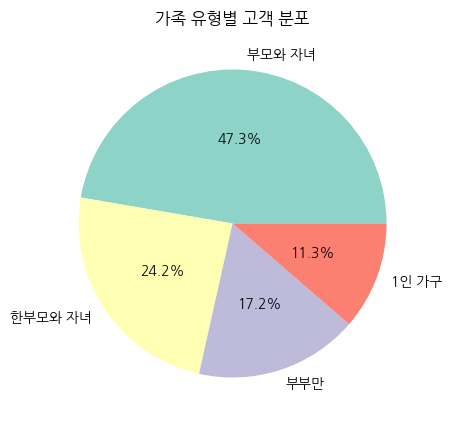

In [9]:
# 1. 가족 유형별 고객 분포
plt.figure(figsize=(5, 5))
df['family_type'].value_counts().plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors, ylabel='',
    pctdistance=0.55, title="가족 유형별 고객 분포"
)
plt.show()

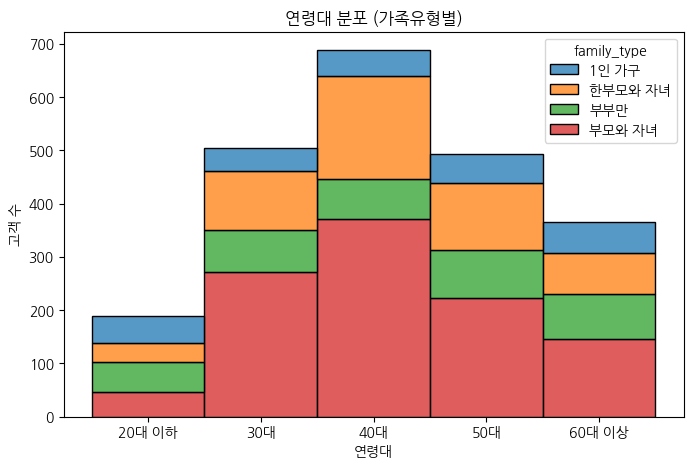

In [10]:
# 2. 연령대 및 가족 유형 분포
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='age_group', hue='family_type', multiple='stack', discrete=True)
plt.title('연령대 분포 (가족유형별)')
plt.ylabel("고객 수"); plt.xlabel("연령대")
plt.show()

## 5) RFM 스코어링 및 등급 부여  
**1차: 균등 가중치 모델**
- Recency, Frequency, Monetary 세 가지 지표에 동일한 가중치(1/3)를 부여하여 RFM 등급을 산출했습니다.  
- **한계점:** VIP 등급의 매출 기여도가 44.2%로 높게 나타났지만, 실제 비즈니스에서는 매출에 직접적으로 기여하는 고객을 더 중요하게 평가해야 할 필요가 있었습니다. 이 모델은 구매 빈도(F)나 최근성(R)이 높은 소액 구매 고객을 과대평가할 수 있습니다.<br>

**2차: 구매 금액(Monetary) 가중치 모델 (최종 채택)**
- **가중치 조정 이유:** "매출 기여도가 높은 핵심 고객 그룹을 명확히 식별한다"는 분석 목표에 따라, **Monetary(구매 금액)에 2.0의 가중치를 부여**했습니다. 이는 Recency와 Frequency가 동일하더라도 더 많이 구매한 고객을 핵심 고객으로 정의하기 위함입니다.
- **결과:** 가중치 조정 후, **VIP 등급의 매출 기여도가 44.2%에서 53.1%로 상승**하며, 매출 중심의 핵심 고객 그룹이 더 명확하게 드러났습니다. 이후 모든 분석은 이 RFM_grade_money 등급을 기준으로 진행합니다.

In [11]:
# Recency는 낮을수록, Frequency와 Monetary는 높을수록 점수가 높아야 함
df['R_score'] = pd.qcut(df['recency'].rank(method='first'), q=5, labels=[5,4,3,2,1]).astype('int')
df['F_score'] = pd.qcut(df['total_num_purchase'].rank(method='first'), q=5, labels=[1,2,3,4,5]).astype('int')
df['M_score'] = pd.qcut(df['total_amount'].rank(method='first'), q=5, labels=[1,2,3,4,5]).astype('int')
df['RFM_score'] = df['R_score'] + df['F_score'] + df['M_score']
print("RFM 스코어링 완료.")

RFM 스코어링 완료.


In [12]:
# Monetary 가중치 모델
r_weight, f_weight, m_weight = 1.0, 1.0, 2.0
df['RFM_index_money'] = (r_weight * df['R_score'] + f_weight * df['F_score'] + m_weight * df['M_score'])

grades = ['Bronze','Silver','Gold','VIP']
df['RFM_grade_money'] = pd.qcut(df['RFM_index_money'], 4, labels=grades)

print("Monetary 가중치 기반 RFM 등급 부여 완료.")
display(df['RFM_grade_money'].value_counts())

Monetary 가중치 기반 RFM 등급 부여 완료.


RFM_grade_money
Bronze    615
Gold      562
VIP       552
Silver    510
Name: count, dtype: int64

## 6) RFM 등급별 매출 기여도  
- **VIP:** 전체 고객의 **24.7%**에 불과하지만, 총매출의 **53.1%**를 차지하는 압도적인 핵심 그룹입니다.
- **Gold:** 고객의 **25.1%**가 총매출의 **35.1%**를 차지하는 중요한 그룹입니다.
- **Silver & Bronze:** 나머지 약 50%의 고객이 총매출의 약 12%를 차지합니다.
- **결론:** 매출의 88% 이상이 상위 50% 고객(VIP, Gold)으로부터 발생하므로, 이들에게 마케팅 자원을 집중하는 것이 효율적임을 시사합니다.

In [13]:
# 등급별 매출 기여도 계산 및 시각화
sales_money = df.groupby('RFM_grade_money', observed=True)['total_amount'].sum()
result_money = sales_money.to_frame('매출')
result_money['매출 기여도(%)'] = (sales_money / sales_money.sum() * 100).round(2)
result_money = result_money.sort_values('매출', ascending=False)
display(result_money)

,매출,매출 기여도(%)
RFM_grade_money,,
VIP,937368900,53.14
Gold,618384000,35.06
Silver,165552400,9.39
Bronze,42698500,2.42


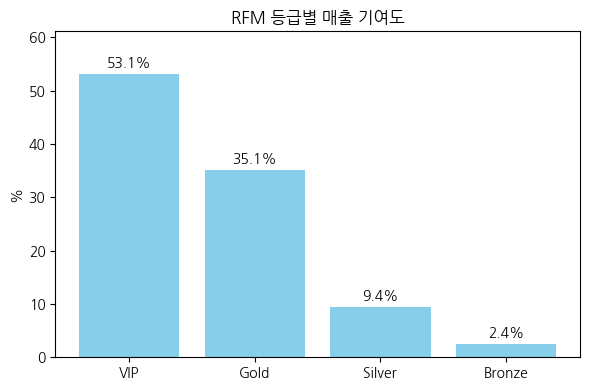

In [14]:
# 시각화
data = result_money['매출 기여도(%)']
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(data.index.astype(str), data.values, color='skyblue')
ax.bar_label(bars, fmt='%.1f%%', padding=3)
ax.set_title('RFM 등급별 매출 기여도')
ax.set_ylabel('%'); ax.set_ylim(0, data.max() * 1.15)
fig.tight_layout()
plt.savefig("rfm_sales.png", dpi=300, bbox_inches='tight')
plt.show()

## 7) 세그먼트별 특성 분석  
**인구통계학적 특성:**
  - **가족 규모:** 등급이 높을수록(VIP, Gold) **1~2인 가구의 비중이 높고**, 등급이 낮아질수록 3인 이상 가구 비중이 증가하는 뚜렷한 경향을 보입니다.
    - **해석:** 1~2인 가구는 다인 가구에 비해 개인의 취향이나 라이프스타일에 따른 소비(예: 고가 주류, 고급 육류)에 더 많은 비용을 지출할 여력이 있을 수 있습니다.<br>

**주요 품목(알콜, 육류) 소비 특성:**
- **알콜: 40~50대 '부모와 자녀'** 가구가 전체 알콜 매출을 주도하며, 이는 VIP와 Gold 등급 내에서도 동일하게 나타나는 핵심 패턴입니다.
- **육류:**
  - **VIP 등급**에서는 **30~40대 '부부만'으로 구성된 가구**가 육류 소비를 주도합니다.
  - **Gold 등급**에서는 **50대 이상 '부부만'으로 구성된 가구**가 육류 소비를 주도합니다.
  - **해석:** VIP와 Gold 등급의 핵심 육류 소비층은 모두 '부부' 가구이지만, 연령대에 따라 선호하는 육류의 종류나 가격대가 다를 수 있음을 시사합니다. 이는 연령대별로 차별화된 마케팅이 필요함을 의미합니다.

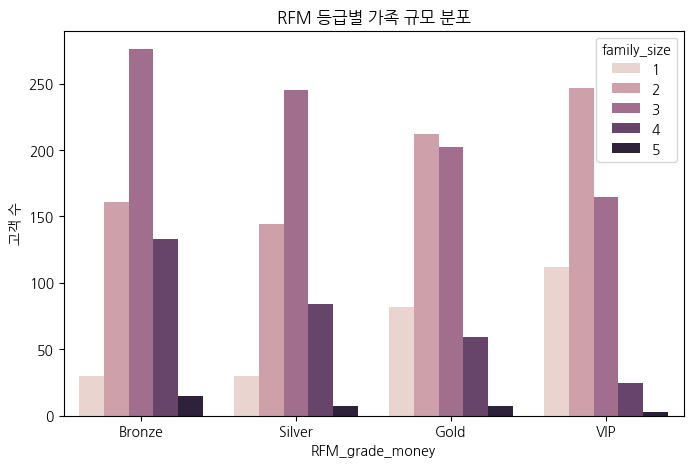

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x='RFM_grade_money', hue='family_size', data=df)
plt.title("RFM 등급별 가족 규모 분포")
plt.savefig("rfm_family_size.png", dpi=300, bbox_inches='tight')
plt.ylabel("고객 수"); plt.show()

In [16]:
# [분석 강화] 등급별 1~2인 가구 비율 계산을 통한 수치적 근거 제시
df['is_small_family'] = df['family_size'].isin([1, 2])
small_family_ratio = df.groupby('RFM_grade_money', observed=True)['is_small_family'].mean().round(3) * 100
print("■ RFM 등급별 1~2인 가구 비중(%):")
display(small_family_ratio)

■ RFM 등급별 1~2인 가구 비중(%):


RFM_grade_money
Bronze    31.1
Silver    34.1
Gold      52.3
VIP       65.0
Name: is_small_family, dtype: float64

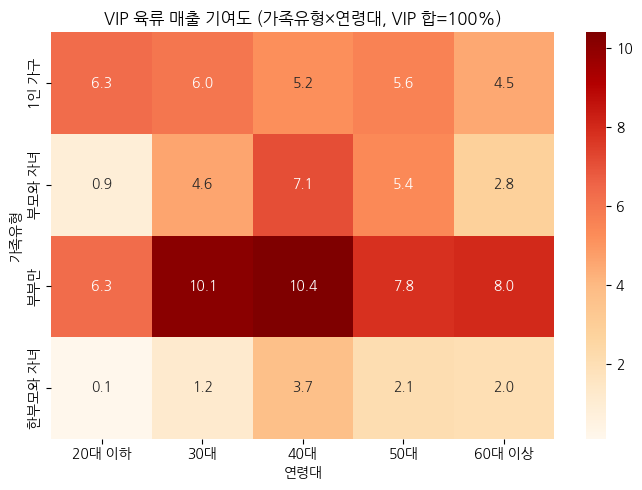

VIP 등급의 육류 매출은 30~40대 '부부만'으로 구성된 가구의 기여도가 높습니다.


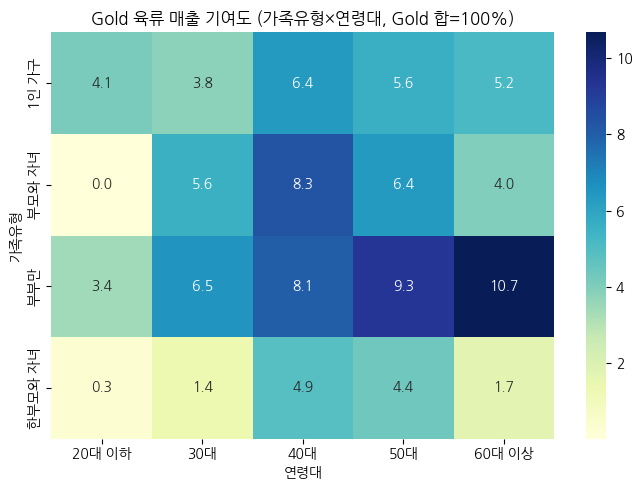

Gold 등급의 육류 매출은 50대 이상 '부부만'으로 구성된 가구의 기여도가 높습니다.


In [17]:
# VIP 등급의 육류 소비 패턴
vip_meat = df.query("RFM_grade_money == 'VIP'")
vip_meat_pivot = vip_meat.pivot_table(index='family_type', columns='age_group',
                                      values='amount_meat', aggfunc='sum', fill_value=0, observed=True)
vip_meat_ratio = (vip_meat_pivot / vip_meat_pivot.to_numpy().sum() * 100).round(1)

plt.figure(figsize=(7, 5))
sns.heatmap(vip_meat_ratio, annot=True, fmt='.1f', cmap='OrRd')
plt.title('VIP 육류 매출 기여도 (가족유형×연령대, VIP 합=100%)'); plt.ylabel('가족유형'); plt.xlabel('연령대')
plt.tight_layout()
plt.savefig("vip_meat.png", dpi=300, bbox_inches='tight')
plt.show()
print("VIP 등급의 육류 매출은 30~40대 '부부만'으로 구성된 가구의 기여도가 높습니다.")

# Gold 등급의 육류 소비 패턴
gold_meat = df.query("RFM_grade_money == 'Gold'")
gold_meat_pivot = gold_meat.pivot_table(index='family_type', columns='age_group',
                                        values='amount_meat', aggfunc='sum', fill_value=0, observed=True)
gold_meat_ratio = (gold_meat_pivot / gold_meat_pivot.to_numpy().sum() * 100).round(2)

plt.figure(figsize=(7, 5))
sns.heatmap(gold_meat_ratio, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Gold 육류 매출 기여도 (가족유형×연령대, Gold 합=100%)'); plt.ylabel('가족유형'); plt.xlabel('연령대')
plt.tight_layout(); plt.show()
print("Gold 등급의 육류 매출은 50대 이상 '부부만'으로 구성된 가구의 기여도가 높습니다.")

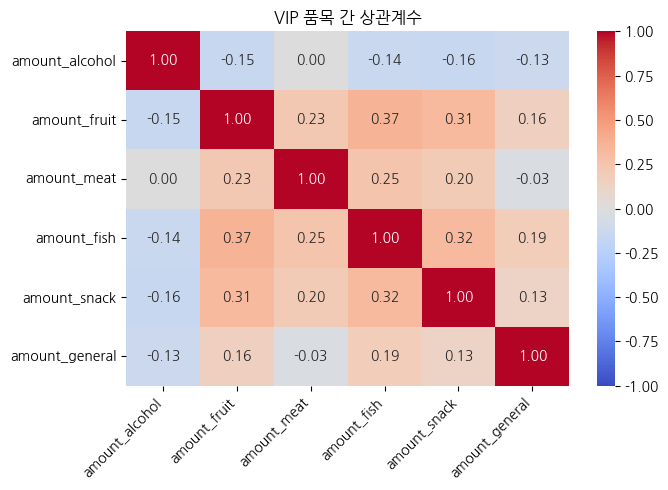

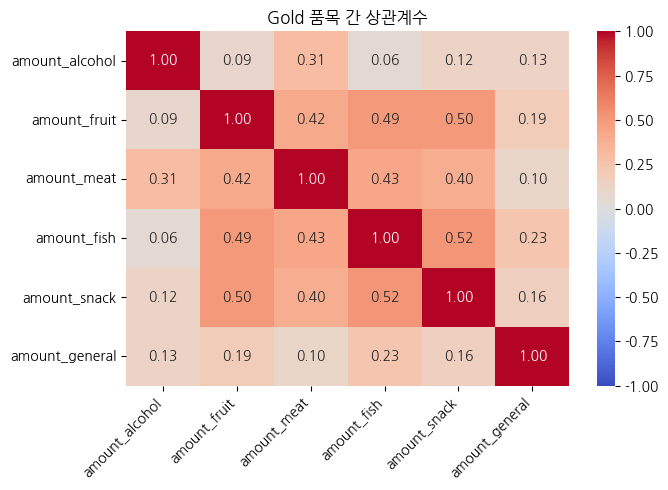

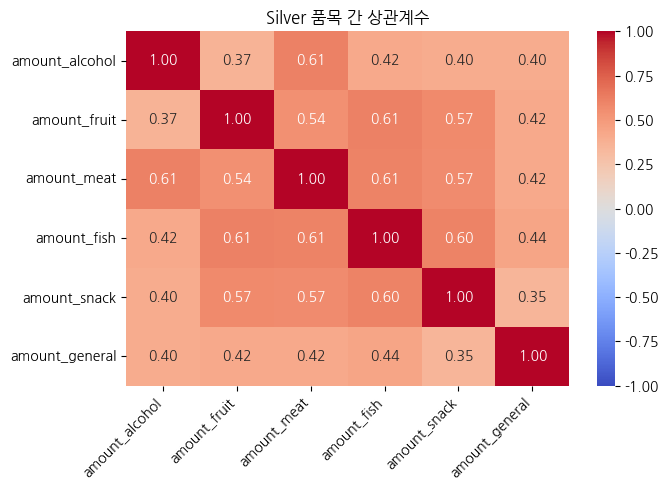

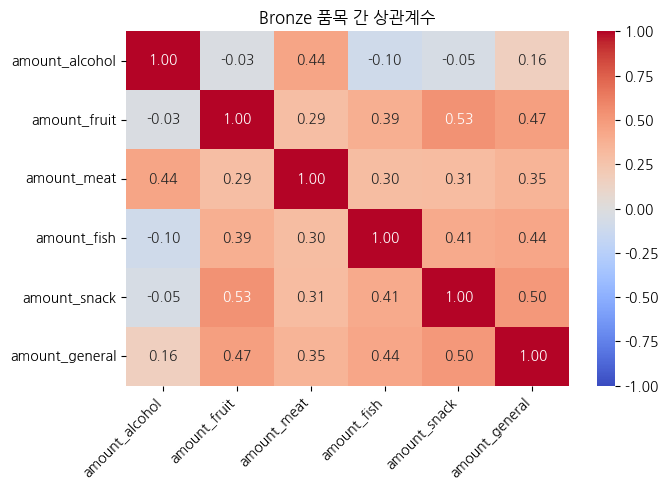

In [18]:
items = ['amount_alcohol','amount_fruit','amount_meat','amount_fish','amount_snack','amount_general']
# 등급 리스트
grades_to_analyze = ['VIP', 'Gold', 'Silver', 'Bronze']

for grade in grades_to_analyze:
    df_items_grade = df.query(f"RFM_grade_money == '{grade}'")[items]
    grade_cm = df_items_grade.corr()
    
    plt.figure(figsize=(7, 5))
    sns.heatmap(grade_cm, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'{grade} 품목 간 상관계수')
    plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
    plt.tight_layout(); plt.show()

## 8) 프로모션 & 채널 효과 분석  
**채널 이용 패턴:**
- 모든 등급에서 **'매장' 채널**의 평균 구매 횟수가 가장 높았습니다.
- **'매장 선호' 그룹**(전체의 22.8%)은 '옴니(균형)' 그룹(76.0%)보다 고객 수는 적지만 **평균 매출과 평균 객단가가 월등히 높았습니다.** 이는 매장 충성 고객이 비즈니스의 핵심적인 수익원임을 의미합니다.<br>

**프로모션 반응:**
- **전반적 경향:** 프로모션 참여 횟수가 높을수록 평균 매출과 객단가가 증가하며, 특히 VIP와 Gold 등급에서 이 효과가 뚜렷했습니다.
- **채널 선호 그룹별 차이:**
  - **'옴니(균형)' 그룹**은 프로모션 참여 횟수가 높을수록 **육류 평균 매출이 증가**했습니다.
  - 반면, **'매장 선호' 그룹**은 프로모션 참여와 **육류 매출 증가 간에 유의미한 관계가 없었습니다**.
  - **해석: '매장 선호' 그룹**의 육류 구매는 가격 할인보다는 품질, 신선도, 브랜드 신뢰 등 다른 요인에 의해 결정되는 **목적성 구매**일 가능성이 높습니다. 반면, **'옴니(균형)' 그룹**은 가격 민감도가 높아 프로모션이 구매 결정에 중요한 영향을 미치는 **기회성 구매** 성향을 보입니다.

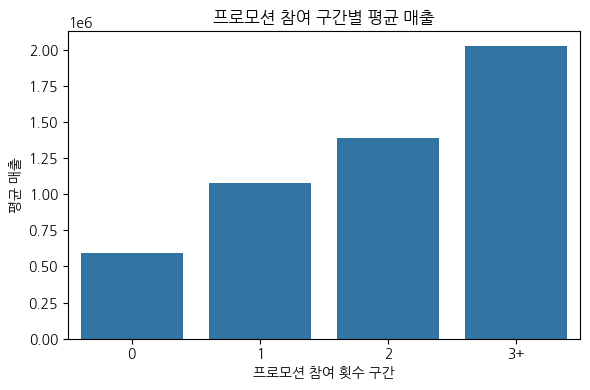

프로모션 참여 횟수가 높을수록 평균 매출이 증가하는 경향을 보입니다.


In [19]:
# 1. 프로모션 참여 횟수와 평균 매출의 관계
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='_promo_bin', y='total_amount', estimator='mean', errorbar=None, order=['0', '1', '2', '3+'])
plt.title('프로모션 참여 구간별 평균 매출'); plt.ylabel('평균 매출'); plt.xlabel('프로모션 참여 횟수 구간')
plt.tight_layout(); plt.show()
print("프로모션 참여 횟수가 높을수록 평균 매출이 증가하는 경향을 보입니다.")

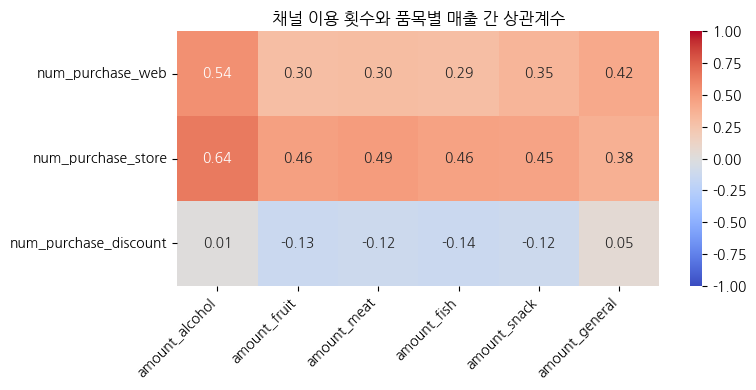

매장과 웹 채널 이용 횟수는 알콜 매출과 높은 양의 상관관계를 보입니다.


In [20]:
# 2. 채널 이용 횟수와 품목별 매출 간 상관관계
corr_matrix = df[ch_cols + items].corr()
corr_channel_item = corr_matrix.loc[ch_cols, items]
plt.figure(figsize=(8,4))
sns.heatmap(corr_channel_item, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('채널 이용 횟수와 품목별 매출 간 상관계수'); plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()
print("매장과 웹 채널 이용 횟수는 알콜 매출과 높은 양의 상관관계를 보입니다.")

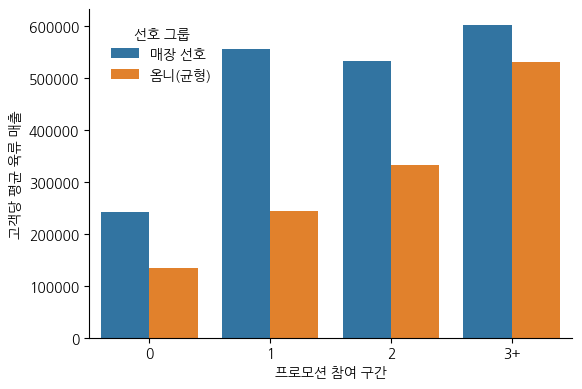

옴니(균형) 그룹은 프로모션 참여에 따라 육류 매출이 증가하지만, 매장 선호 그룹은 그렇지 않습니다.


In [21]:
# 3. 채널 선호 그룹과 프로모션 반응 차이 분석 (주요 품목: 육류)
plot_df = df.melt(id_vars=['_promo_bin', 'channel_pref'], value_vars=['amount_meat'],
                  var_name='item', value_name='amount')
keep_channels = ['매장 선호', '옴니(균형)']
plot_df = plot_df[plot_df['channel_pref'].isin(keep_channels)]

g = sns.catplot(
    data=plot_df, kind='bar',
    x='_promo_bin', y='amount', hue='channel_pref',
    hue_order=keep_channels, order=['0', '1', '2', '3+'],
    errorbar=None, height=4, aspect=1.2
)
g.set_axis_labels("프로모션 참여 구간", "고객당 평균 육류 매출")
g.legend.set_title("선호 그룹")
g._legend.set_loc('upper left')
g._legend.set_bbox_to_anchor((0.02, 0.98), transform=g.axes[0,0].transAxes)
plt.tight_layout()
plt.savefig("channel_pref_and_promo.png", dpi=300, bbox_inches='tight')
plt.show()
print("옴니(균형) 그룹은 프로모션 참여에 따라 육류 매출이 증가하지만, 매장 선호 그룹은 그렇지 않습니다.")

## 9) 결론 및 시사점

**분석 요약:** RFM 분석을 통해 **매출 기여도가 높은 VIP/Gold 등급**을 핵심 고객으로 정의했으며, 이들은 주로 **1~2인 가구**로 구성되어 있습니다. 특히 이들 중 **'매장 선호'** 그룹은 프로모션에 둔감하지만 객단가가 높은 **충성 고객**이며, **'옴니(균형)' 그룹**은 프로모션에 민감하게 반응하는 **기회 탐색형 고객**의 특성을 보입니다.  

**최종 전략 제언:**
1. **VIP '매장 선호' 그룹 대상 CRM 전략 제안:**
    - **타겟:** VIP/Gold 등급의 '매장 선호' 고객, 특히 육류 구매력이 높은 30~50대 부부 가구.
    - **전략:** 이들은 가격 할인의 영향을 적게 받으므로, 단순 할인 프로모션은 비효율적입니다. 대신, **프리미엄 육류 신상품 런칭 시 우선 시식 기회 제공, 와인 페어링 클래스 등 매장 중심의 특별한 경험을 제공하는 CRM(고객 관계 관리) 전략**을 통해 로열티를 강화해야 합니다.<br><br>

2. **'옴니(균형)' 그룹 대상 프로모션 최적화 방안:**
    - **타겟:** '옴니(균형)' 채널을 이용하는 모든 등급의 고객.
    - **전략:** 이들은 프로모션을 통해 추가 매출을 유도할 수 있는 잠재력이 큽니다. **웹/앱 푸시 알림을 통한 육류 할인 쿠폰 제공, 특정 품목(예: 생선, 과일, 스낵) 동시 구매 시 추가 할인, 장바구니 금액에 따른 배송비 할인 등 온라인과 오프라인을 연계한 데이터 기반 개인화 프로모션**을 통해 객단가를 높이는 전략이 효과적일 것입니다.